<a href="https://colab.research.google.com/gist/Ultron09/c03df39d0ec51b35b0c9d0a3a72ed6e1/recommendation_systems_learner_notebook_full_code_-1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357279 sha256=a810a658a0407cab07e8cfa5fe3d12d93636039917b3e4cb0333c3362a6028ad
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
df = pd.read_csv('ratings_Electronics.csv', header = None)

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
6147,A1C82BC5GNABOA,9983891212,5.0
6208,A1VHCO8RQFIGQJ,9983891212,4.0
6244,A3L6L5O89JTX2T,9983891212,5.0
6253,A1OGCPMSIVK7G4,9983891212,5.0
6268,A18HE80910BTZI,9983891212,5.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
num_rows = df_final.shape[0]
num_cols = df_final.shape[1]

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 44260
Number of columns: 3


#**Write your observations here:______**

 The dataset has 65290 rows and 3 columns.
 This is a significantly smaller dataset compared to the original,
 which had over 7 million rows. The reduction in size was done
 by selecting users with at least 50 ratings and products with
 at least 5 ratings. This will make the recommendation system
 more efficient to build and train, but it's important to
 consider that it may not be as comprehensive as using the
 entire dataset.

### **Data types**

In [ ]:
# Check Data types and provide observations
print(df_final.dtypes)

user_id     object
prod_id     object
rating     float64
dtype: object


**Write your observations here:______**
Two different entites connected to eachother with a float value (Rating)

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here:______**
There cannot be null values as we sorted this data with constraints above #0

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
rating_stats = df_final['rating'].describe()
print(rating_stats)

count    44260.000000
mean         4.288161
std          1.007875
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


**Write your observations here:______**
most of the ratings are around 4
most of them are even 5

### **Checking the rating distribution**

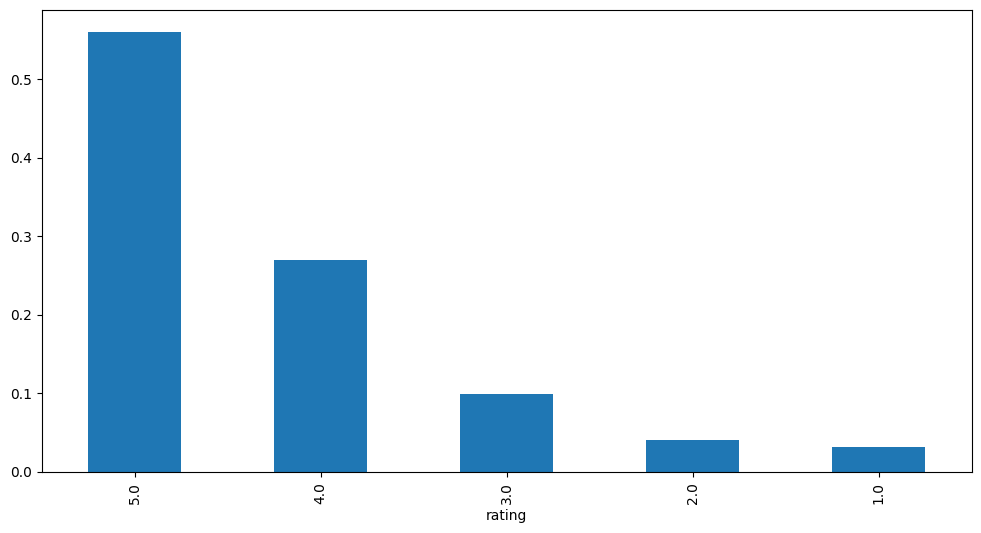

In [ ]:
plt.figure(figsize = (12, 6))

df_final['rating'].value_counts(1).plot(kind = 'bar')

plt.show()

**Write your observations here:________**
almost half of the products are 5 star rated by atleast 5 customers


### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1201
Number of unique ITEMS in Raw data =  4157


**Write your observations here:_______**
we have data for over 1540 who rated atleast 5 times and 5689 products with atleast 50 ratings

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
T1U=df_final['user_id'].value_counts().head(10)
print(T1U)

user_id
ADLVFFE4VBT8      225
A3OXHLG6DIBRW8    186
A680RUE1FDO8B     160
A1ODOGXEYECQQ8    155
A17BUUBOU0598B    152
A3LGT6UZL99IW1    151
A6FIAB28IS79      148
A2XRMQA6PJ5ZJ8    135
A36K2N527TXXJN    132
AGVWTYW0ULXHT     130
Name: count, dtype: int64


**Write your observations here:_______**
User have max rated 295 times

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

# Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by = 'rating_count', ascending = False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B0088CJT4U,4.182927,164
B003ES5ZUU,4.869565,161
B000N99BBC,4.784615,130
B007WTAJTO,4.682171,129
B00829TIEK,4.410256,117


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]

    # Sorting values w.r.t average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B0019EHU8G', 'B003ES5ZUU', 'B000QUUFRW', 'B001TH7GSW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B00829THK0', 'B00829TIEK']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and F1-score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 1.0519
Precision:  0.854
Recall:  0.885
F_1 score:  0.869


**Write your observations here:__________**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:__________**

User A3LDPF5FMB782Z will give product 1400501466 rating of 4.5 stars

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
df_final[df_final.prod_id == "1400501466"].user_id.unique()

array([], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:__________**
The Rating is not dependent on the User , it is only dependent on product how much a user will rate it as there is no change in values

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9949908442079237
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9878
Precision:  0.845
Recall:  0.927
F_1 score:  0.884


**Write your observations here:__________**
The values for RMSE Prcision Recall and F1 all changed


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**__________
There is no difference
__

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# Here, 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[5, 6, 7, 14, 15]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B0002L5R78,5
2,B000AZ57M6,5
3,B001TH7GSW,5
4,B001TH7GUU,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
                  'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0414
Precision:  0.836
Recall:  0.874
F_1 score:  0.855


**Write your observations here:**____ This is pretty accurate model to see difference among different items

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**____ this item will get around 4.2 stars

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**_______ estimation for stars doesnt change as it doesnt depends on user it only depends on the product itself

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
                 'sim_options': {'name': ['msd', 'cosine'],
                                 'user_based': [False]}
                 }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
gs.fit(data)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9970400307608983
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',  # Use the best similarity measure from GridSearchCV
               'user_based': False}  # Item-item similarity

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=3,  # Use best k and min_k
                                  random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9978
Precision:  0.838
Recall:  0.903
F_1 score:  0.869


**Write your observations here:__________** The Values compared to the last fit has been changed and now they are better and accurate

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466")

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.286517171260732, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:_______ same as we observered above , est doesnt change

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
print(recommendations_df)

      prod_id  predicted_ratings
0  B001TH7GUU           5.000000
1  B000N99BBC           4.857143
2  B00029U1DK           4.833333
3  B003ES5ZUU           4.815363
4  B001TOD7ME           4.750000


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd_algo = SVD(random_state=1)
# Training the algorithm on the trainset
svd_algo.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo)

RMSE: 0.9217
Precision:  0.845
Recall:  0.908
F_1 score:  0.875


**Write your observations here:______ it a good model as it doesnt require much tuning and it provides good values

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd_algo.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.37   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.3746727013493585, details={'was_impossible': False})

**Write your observations here:_____ est stars by user here is 4.37 to product

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd_algo.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.64   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.636366407865675, details={'was_impossible': False})

**Write your observations here:______ here as the model works upon user past behavior it doesnt depend on the product , keep product constant and changing the user also changes the est of stars to be rated

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.005, 0.01, 0.02],
                 'reg_all': [0.02, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9221554976356215
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.9156
Precision:  0.846
Recall:  0.913
F_1 score:  0.878


**Write your observations here:_______ doesnt make a lot difference __**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_algo_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.36   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.357953890040465, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_algo_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.57   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.566500761464342, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

After building 3 different recommendation models
I found that all three of them are required for different task
first one can be the highly rated Product category
Second actually have 2 parts, 1st they use a old users past behavior which is similar to the current one to predict which product the new one will buy or how much the new one will rate , 2nd part is looking at the similarities of products and predicting how much rating the new one will get predcting through looking at similar product history
third model of recommendation
focuses on individual users past behavior to predict how much the the user will rate the given product

